# **<center>Using CNN to predict angles and throttles<center>**
    
In this notebook, you can download images obtained with the donkey car. You can use them to launch a training in order to get a model for the donkey car.
Several options are available :

- The number of image to learn from
- The possibility to invert them to also learn turning right
    
    

In [2]:
import json
import shutil
import random
import pathlib
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import IPython.display as display

import mlflow
import mlflow.tensorflow
import mlflow.keras

import tensorflow as tf

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import MSLE, MAE, MSE
from tensorflow.keras.losses import MSE, MSLE
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from xebikart.images import transformer as T
import xebikart.dataset as dataset

from sklearn.model_selection import train_test_split

%matplotlib inline

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

using donkey version: 2.5.8 ...


In [3]:
tf.__version__

'1.14.0'

In [4]:
tf.enable_eager_execution()

In [5]:
# parameters
# dataset parameters
tubes_root_folder = "file:/workspace/xebikart-ml-tubes"
tubes_folders = [
    #"tub.v4.01",
    #"tub.v4.02",
    "tub.v4.03",
    "tub.v5.03"
]
test_size=0.2

# training parameters
batch_size = 32
shuffle_size = 200
n_epochs = 50
learning_rate = 1e-3

# Load data

Download tubes from : https://github.com/xebia-france/xebikart-ml-tubes

In [6]:
raw_tubes_df = dataset.get_tubes_df(tubes_root_folder, tubes_folders, tubes_extension=".tar.gz")
tubes_df = raw_tubes_df.rename(columns={"cam/image_array": "images_path", "user/angle": "angles", "user/throttle": "throttles"})
tubes_df.count()
images_path = tubes_df["images_path"].tolist()

5849088/5841400 [==============================] - 0s 0us/step


##### **- Display some examples before and after preprocessing**

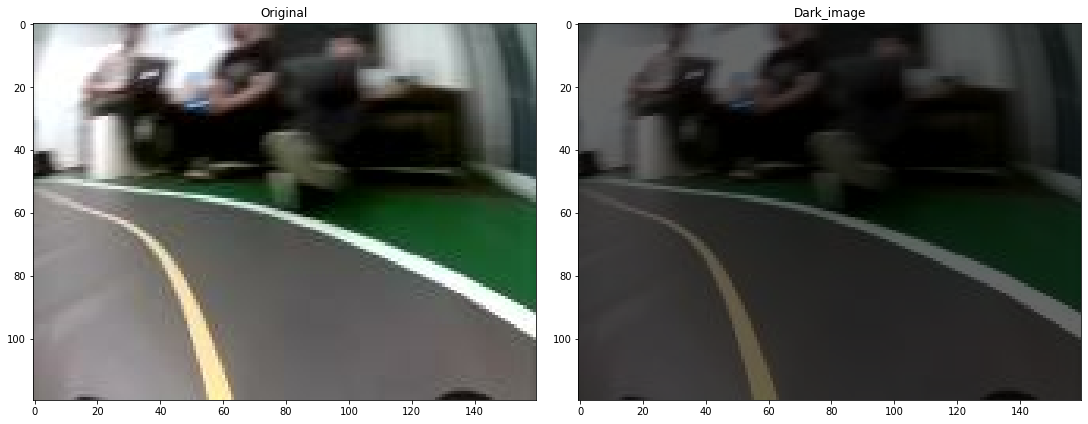

In [7]:
random_image_path = tubes_df.sample()["images_path"].values[0]

tf_image_original   = T.read_image(random_image_path)
tf_image_night      = tf.image.adjust_gamma(tf_image_original, gamma=1, gain=0.4)

fig, axs = plt.subplots(1, 2, figsize=(15,15), constrained_layout=True)
axs[0].set_title("Original")
axs[0].imshow(tf_image_original)
axs[1].set_title("Dark_image")
axs[1].imshow(tf_image_night)
plt.show()

In [8]:
def calculate_sum(image_path):
    tf_image   = T.read_image(image_path)
    tf_image_unint32 = tf.dtypes.cast(tf_image, "uint32")
    tf_image_sum = tf.math.reduce_sum(tf_image_unint32)
    return tf_image_sum

In [9]:
def calculate_sum_dark(image_path):
    tf_image   = T.read_image(image_path)
    tf_image = tf.image.adjust_gamma(tf_image, gamma=1, gain=0.4)
    tf_image_unint32 = tf.dtypes.cast(tf_image, "uint32")
    tf_image_sum = tf.math.reduce_sum(tf_image_unint32)
    return tf_image_sum

# Build a dataset of images

In [10]:
ds_image = tf.data.Dataset.from_tensor_slices(images_path)

In [14]:
(9497*2)/84

226.11904761904762

In [20]:
%%time
sums = []
sums_dark = []
for path in images_path :
    sum_ = calculate_sum(path)
    sums.append(sum_)
    
    sum_dark = calculate_sum_dark(path)
    sums_dark.append(sum_dark)

CPU times: user 35.3 s, sys: 10.4 s, total: 45.7 s
Wall time: 1min 24s


In [21]:
np.mean(sums)

6208868.832789302

In [22]:
np.std(sums)

678516.4798218178

In [23]:
np.mean(sums_dark)

2460931.4697272824

In [24]:
np.std(sums_dark)

271352.41267552925